In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [3]:
df = pd.read_csv("/Users/maryellenfaulconer/Documents/NFL_Big_Data_Bowl/NFL-Big-Data-Bowl-2026/data/train/input_2023_w11.csv")
print(df.head())

      game_id  play_id  player_to_predict  nfl_id  frame_id play_direction  \
0  2023111600       56               True   52515         1          right   
1  2023111600       56               True   52515         2          right   
2  2023111600       56               True   52515         3          right   
3  2023111600       56               True   52515         4          right   
4  2023111600       56               True   52515         5          right   

   absolute_yardline_number          player_name player_height  player_weight  \
0                        35  Akeem Davis-Gaither           6-2            215   
1                        35  Akeem Davis-Gaither           6-2            215   
2                        35  Akeem Davis-Gaither           6-2            215   
3                        35  Akeem Davis-Gaither           6-2            215   
4                        35  Akeem Davis-Gaither           6-2            215   

   ...         player_role      x      y    

In [4]:
# --- 1. Compute base features (vectorized, no repetition) ---
df = df.sort_values(["nfl_id", "game_id", "play_id", "frame_id"])

# Precompute radians once
dir_rad = np.deg2rad(df["dir"].to_numpy())

# Vectorized calculations
df["vx"] = df["s"].to_numpy() * np.cos(dir_rad)
df["vy"] = df["s"].to_numpy() * np.sin(dir_rad)
df["ax"] = df["a"].to_numpy() * np.cos(dir_rad)
df["ay"] = df["a"].to_numpy() * np.sin(dir_rad)
df["dir_rad"] = dir_rad

# --- 2. Add lag and lead features (do ONE groupby, not 12) ---
group_cols = ["nfl_id", "game_id", "play_id"]
gb = df.groupby(group_cols, group_keys=False)

# Define lag/lead columns dynamically
lag_features = ["x", "y", "vx", "vy", "ax", "ay"]
for lag in [1, 2]:
    shifted = gb[lag_features].shift(lag)
    shifted.columns = [f"{c}_lag{lag}" for c in shifted.columns]
    df = pd.concat([df, shifted], axis=1)

# Lead (targets)
lead = gb[["x", "y"]].shift(-1)
lead.columns = ["x_next", "y_next"]
df = pd.concat([df, lead], axis=1)

# Drop missing target rows
df = df.dropna(subset=["x_next", "y_next"]).reset_index(drop=True)


In [5]:
# --- 3. Convert categorical columns efficiently ---
for col in ["player_role", "player_position", "play_direction"]:
    df[col] = df[col].astype("category")

# --- 4. Prepare subset for prediction ---
to_predict = df.loc[df["player_to_predict"]].copy()

# Vectorized one-hot encoding (no apply loops)
to_predict["play_direction_num"] = (to_predict["play_direction"].cat.codes == to_predict["play_direction"].cat.categories.get_loc("right")).astype(int)

# Map positions + roles directly (avoids multiple boolean scans)
to_predict["player_position_WR"] = (to_predict["player_position"] == "WR").astype(int)
to_predict["player_position_RB"] = (to_predict["player_position"] == "RB").astype(int)
to_predict["player_position_QB"] = (to_predict["player_position"] == "QB").astype(int)
to_predict["player_role_Targeted"] = (to_predict["player_role"] == "Targeted Receiver").astype(int)
to_predict["player_role_Passer"] = (to_predict["player_role"] == "Passer").astype(int)
to_predict["player_role_Def"] = (to_predict["player_role"] == "Defensive Coverage").astype(int)

# --- 5. Unique players list ---
players = to_predict["nfl_id"].unique()

In [9]:
to_predict.columns

## SO... when we lag some rows don't have like a last frame or two frames ago since that is the first frame... for now I am going to just DROP those observations, 
# but maybe we can do something smarter later like fill with zeros or the first available value.
lag_cols = [col for col in to_predict.columns if "lag" in col]
to_predict = to_predict.dropna(subset=lag_cols)


In [10]:
## start wth just one game to test
one_game = to_predict[to_predict['game_id'] == 2023111906]
one_game.columns


Index(['game_id', 'play_id', 'player_to_predict', 'nfl_id', 'frame_id',
       'play_direction', 'absolute_yardline_number', 'player_name',
       'player_height', 'player_weight', 'player_birth_date',
       'player_position', 'player_side', 'player_role', 'x', 'y', 's', 'a',
       'dir', 'o', 'num_frames_output', 'ball_land_x', 'ball_land_y', 'vx',
       'vy', 'ax', 'ay', 'dir_rad', 'x_lag1', 'y_lag1', 'vx_lag1', 'vy_lag1',
       'ax_lag1', 'ay_lag1', 'x_lag2', 'y_lag2', 'vx_lag2', 'vy_lag2',
       'ax_lag2', 'ay_lag2', 'x_next', 'y_next', 'play_direction_num',
       'player_position_WR', 'player_position_RB', 'player_position_QB',
       'player_role_Targeted', 'player_role_Passer', 'player_role_Def'],
      dtype='object')

In [11]:
feature_cols = ["x", "y", "vx", "vy", "ax", "ay", "x_lag1", "y_lag1", "vx_lag1", "vy_lag1",
                  "ax_lag1", "ay_lag1", "x_lag2", "y_lag2", "vx_lag2", "vy_lag2", "ax_lag2",
                  "ay_lag2", "o", "dir", "play_direction_num", "player_position_WR", 
                  "player_position_RB", "player_position_QB", "player_role_Targeted", 
                  "player_role_Passer", "player_role_Def", "ball_land_x", "ball_land_y"]

targets = ["x_next", "y_next"]

In [12]:
# --- 2. Subset for players to predict ---
df_model = one_game.loc[one_game["player_to_predict"], feature_cols + targets].copy()

# --- 3. Split X and y ---
X = df_model[feature_cols]
y = df_model[targets]

In [13]:
## splitting this ONE GAME into test and train for now
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [14]:
# standardize numeric features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [15]:
## Build neural network model
model = Sequential([
    Dense(128, activation="relu", input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation="relu"),
    Dropout(0.2),
    Dense(2, activation="linear")  # outputs: x_next, y_next
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="mse",      # mean squared error for continuous outputs
    metrics=["mae"]  # mean absolute error for interpretability
)

/opt/anaconda3/envs/ML-env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
## train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=128,
    verbose=1
)


Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2134.3066 - mae: 40.6945 - val_loss: 1676.5012 - val_mae: 35.7966
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1113.0005 - mae: 27.7455 - val_loss: 419.8751 - val_mae: 16.2033
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 274.7437 - mae: 13.0115 - val_loss: 166.5218 - val_mae: 10.2098
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 166.1400 - mae: 10.2772 - val_loss: 112.9848 - val_mae: 8.3921
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 132.2891 - mae: 9.1014 - val_loss: 84.8663 - val_mae: 7.1047
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 108.5415 - mae: 8.1136 - val_loss: 68.0687 - val_mae: 6.2913
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 99.0556 - mae: 7.7636 - val_loss: 58.2581 - val_mae: 5.7833
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 85.7197 - mae: 7.1973 - val_loss: 48.6826 - val_mae: 5.2585
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━

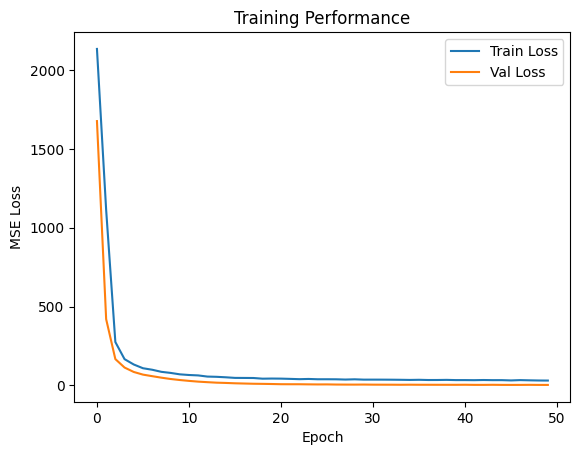

Validation MAE: 1.297 yards


In [20]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Training Performance")
plt.show()

# Numeric evaluation
loss, mae = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation MAE: {mae:.3f} yards")

In [21]:
## predict on validation set
y_pred = model.predict(X_val)
pred_df = pd.DataFrame(y_pred, columns=["x_pred", "y_pred"])
pred_df.head()


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step


,x_pred,y_pred
0,53.589508,13.629505
1,25.546923,20.540827
2,43.931633,35.412113
3,89.332603,19.231430
4,39.065571,20.696060
